In [111]:
import timeit
from rfgap import RFGAP
import pandas as pd
from dataset import dataprep
import numpy as np

import sklearn

from distutils.version import LooseVersion
if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):
    # In sklearn version 0.24, forest module changed to be private.
    from sklearn.ensemble._forest import _generate_unsampled_indices
    from sklearn.ensemble import _forest as forest
    from sklearn.ensemble._forest import _generate_sample_indices


import matplotlib.pyplot as plt

/tmp/ipykernel_3047578/1388939584.py:10: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(sklearn.__version__) >= LooseVersion("0.24"):


In [112]:
# Read in the data
data   = pd.read_csv('../datasets/waveform.csv', sep = ',')
x, y   = dataprep(data)
n, d   = x.shape
n_classes = len(y.unique())

In [113]:
rf = RFGAP(random_state = 0)
rf.fit(x, y)

tree = rf.estimators_[0]

In [123]:
def tree_rfgap(tree, x):

    in_bag_inds = _generate_sample_indices(tree.random_state, n, n)

    # in_bag_bool = np.zeros(n, dtype = int)
    # in_bag_bool[in_bag_inds] = 1


    oob_inds = _generate_unsampled_indices(tree.random_state, n, n)
    in_bag_counts = np.bincount(in_bag_inds, minlength = n)
    leaves = tree.apply(x)
    # in_bag_leaves = leaves * in_bag_bool

    # Is bincount faster than the following?
    # oob_bool = np.zeros(n, dtype = int)
    # oob_bool[oob_inds] = 1

    oob_bool = np.bincount(oob_inds, minlength = n)
    oob_leaves = leaves * oob_bool

    matches = np.equal.outer(oob_leaves, leaves)

    prox = matches * in_bag_counts
    M = prox.sum(axis = 1)
    M[M == 0] = 1
    prox = prox / M[:, np.newaxis]

    

    return prox



In [124]:
prox = tree_rfgap(tree, x)

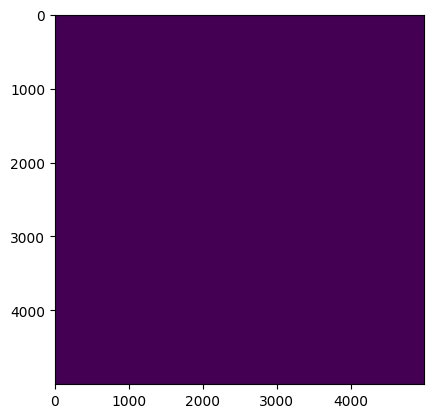

In [125]:
plt.imshow(prox)

In [126]:
for tree in rf.estimators_:
    prox = tree_rfgap(tree, x)

In [122]:
rf.get_proximities()

<5000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 4433919 stored elements in Compressed Sparse Row format>

In [129]:
from joblib import Parallel, delayed



# Use joblib to parallelize the square function
results = Parallel(n_jobs=-1)(delayed(tree_rfgap)(i, x) for i in rf.estimators_)